### Batch Inference Pipeline for Aggregate Loan Default Statistics

This notebook performs the following actions:

* gets a feature view object with its name/version from Hopsworks
* downloads a Pandas DataFrame with new inference data from Hopsworks using the feature view and the call `fv.get_batch_data(start_time="...")`
* downloads the model from Hopsworks using with its name/version
* makes predictions for all input rows of features in the DataFrame using the model
* logs all the prediction results and features to a `loan_monitoring` feature group in Hopsworks


The *output of this notebook is a dashboard* -  a confusion matrix showing the ratio of predicted good/bad loans for the batch inference data. It is uploaded to Hopsworks and can be viewed from the file system in Hopsworks.

In [ ]:
!pip install hopsworks

In [18]:
import hopsworks
import pandas as pd
import joblib
import os
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2

In [19]:
fv_version=1
model_version=1
start_time_data="2016-11-01"
end_time_data="2016-12-01"

In [20]:
import os

# Hosted notebook environments may not have the local features package
def need_download_modules():
    if 'google.colab' in str(get_ipython()):
        return True
    if 'HOPSWORKS_PROJECT_ID' in os.environ:
        return True
    return False

if need_download_modules():
    print("Downloading modules")
    os.system('mkdir -p features')
    os.system('cd features && wget https://raw.githubusercontent.com/logicalclocks/hopsworks-tutorials/dev/loan_approval/features/loans.py')
    os.system('cd features && wget https://raw.githubusercontent.com/logicalclocks/hopsworks-tutorials/dev/loan_approval/features/applicants.py')
else:
    print("Local environment")

Local environment


In [21]:
import hopsworks

proj = hopsworks.login()
fs = proj.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://35.187.37.222:443/p/119
Connected. Call `.close()` to terminate connection gracefully.


In [32]:
fv = fs.get_feature_view(name="loans_approvals", version=fv_version)

In [33]:
arr = [f.name for f in fv.schema]
print(arr)

['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'loan_status', 'purpose', 'zip_code', 'home_ownership', 'annual_inc', 'verification_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


In [34]:
def retrieve_data(feature_view):
    batch_data = feature_view.get_batch_data(
        start_time=start_time_data, end_time=end_time_data)
    return batch_data

df = retrieve_data(fv)
df

,loan_amnt,term,int_rate,installment,sub_grade,purpose,zip_code,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,16000.0,60 months,13.99,372.21,C3,credit_card,30723,MORTGAGE,88000.0,Verified,17.06,9.0,1,17945.0,47.0,31.0,w,INDIVIDUAL,0.0,0.0
1,20000.0,60 months,24.74,583.99,E3,debt_consolidation,30723,MORTGAGE,79000.0,Verified,29.73,17.0,0,39602.0,91.2,27.0,w,INDIVIDUAL,4.0,0.0
2,7200.0,36 months,13.49,244.30,C2,debt_consolidation,29597,RENT,59000.0,Not Verified,16.38,14.0,1,12371.0,40.8,36.0,f,INDIVIDUAL,0.0,1.0
3,28800.0,60 months,13.49,662.54,C2,debt_consolidation,48052,MORTGAGE,60000.0,Not Verified,16.56,11.0,0,57106.0,30.5,15.0,w,INDIVIDUAL,2.0,0.0
4,35000.0,60 months,22.74,981.45,E1,debt_consolidation,70466,RENT,77000.0,Source Verified,34.33,17.0,0,27822.0,64.4,24.0,w,INDIVIDUAL,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,7300.0,36 months,15.99,256.62,C5,debt_consolidation,0,MORTGAGE,105000.0,Source Verified,8.42,13.0,0,6325.0,19.4,18.0,w,INDIVIDUAL,0.0,0.0
437,13000.0,60 months,19.99,344.35,D4,debt_consolidation,0,MORTGAGE,65000.0,Source Verified,24.06,13.0,0,18427.0,50.8,30.0,w,INDIVIDUAL,4.0,0.0
438,30000.0,36 months,10.49,974.94,B2,credit_card,48052,OWN,170000.0,Source Verified,15.85,11.0,0,76544.0,48.3,24.0,w,INDIVIDUAL,3.0,0.0
439,15000.0,60 months,13.99,348.95,C3,debt_consolidation,70466,RENT,70000.0,Source Verified,12.71,17.0,0,17043.0,43.4,32.0,w,INDIVIDUAL,0.0,0.0


In [35]:
def get_model(project):
    mr = project.get_model_registry()
    model = mr.get_model("lending_model", version=model_version)
    model_dir = model.download()
    return joblib.load(model_dir + "/lending_model.pkl")

model = get_model(proj)

Connected. Call `.close()` to terminate connection gracefully.


In [36]:
predictions = model.predict(df)
predictions

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [37]:
np.unique(predictions, return_counts=True)

(array([0, 1]), array([ 11, 430]))

In [38]:
cols = []
for td in fv.schema:
    cols.append(td.name)

predictions_df = pd.DataFrame(predictions, columns=["prediction"])
predictions_df

,prediction
0,1
1,1
2,1
3,1
4,0
...,...
436,1
437,1
438,1
439,1


In [39]:
import time

fg = fs.get_feature_group(name="loans", version=1)
labels_df = fg.read()

In [40]:
monitor_df = df.copy()
monitor_df['prediction'] = predictions_df

monitor_df['prediction'] = predictions_df.prediction.map({1:'Fully Paid', 0:'Charged Off'})

monitor_df['outcome'] = labels_df['loan_status']
monitor_df['prediction_ts'] = pd.datetime.now()

monitor_df['id'] = monitor_df.index

monitor_df

,loan_amnt,term,int_rate,installment,sub_grade,purpose,zip_code,home_ownership,annual_inc,verification_status,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,prediction,outcome,prediction_ts,id
0,16000.0,60 months,13.99,372.21,C3,credit_card,30723,MORTGAGE,88000.0,Verified,...,47.0,31.0,w,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,0
1,20000.0,60 months,24.74,583.99,E3,debt_consolidation,30723,MORTGAGE,79000.0,Verified,...,91.2,27.0,w,INDIVIDUAL,4.0,0.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,1
2,7200.0,36 months,13.49,244.30,C2,debt_consolidation,29597,RENT,59000.0,Not Verified,...,40.8,36.0,f,INDIVIDUAL,0.0,1.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,2
3,28800.0,60 months,13.49,662.54,C2,debt_consolidation,48052,MORTGAGE,60000.0,Not Verified,...,30.5,15.0,w,INDIVIDUAL,2.0,0.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,3
4,35000.0,60 months,22.74,981.45,E1,debt_consolidation,70466,RENT,77000.0,Source Verified,...,64.4,24.0,w,INDIVIDUAL,0.0,0.0,Charged Off,Fully Paid,2023-05-12 09:32:19.714647,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,7300.0,36 months,15.99,256.62,C5,debt_consolidation,0,MORTGAGE,105000.0,Source Verified,...,19.4,18.0,w,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,436
437,13000.0,60 months,19.99,344.35,D4,debt_consolidation,0,MORTGAGE,65000.0,Source Verified,...,50.8,30.0,w,INDIVIDUAL,4.0,0.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,437
438,30000.0,36 months,10.49,974.94,B2,credit_card,48052,OWN,170000.0,Source Verified,...,48.3,24.0,w,INDIVIDUAL,3.0,0.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,438
439,15000.0,60 months,13.99,348.95,C3,debt_consolidation,70466,RENT,70000.0,Source Verified,...,43.4,32.0,w,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-05-12 09:32:19.714647,439


In [41]:
loan_monitoring_fg = fs.get_or_create_feature_group(name="loan_monitoring",
                                    version=1,
                                    description="Lending Club Loan Predictions and Outcomes",
                                    primary_key=['id'],
                                    event_time='prediction_ts'
)

In [42]:
loan_monitoring_fg.insert(monitor_df, write_options={"wait_for_job" : False})

Uploading Dataframe: 0.00% |          | Rows 0/441 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: loan_monitoring_1_offline_fg_backfill
Job started successfully, you can follow the progress at 
https://35.187.37.222/p/119/jobs/named/loan_monitoring_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fa69aaf7190>, None)

In [43]:
from sklearn.metrics import confusion_matrix

predictions = monitor_df[['prediction']]
labels = monitor_df[['outcome']]

results = confusion_matrix(labels, predictions)
print(results)

[[  5  78]
 [  6 352]]


,Predicted Defaulted,Predicted Paid Off
True Defaulted,5,78
True Paid Off,6,352


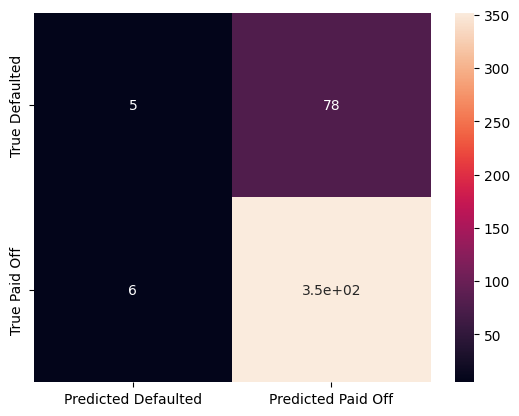

In [44]:
from matplotlib import pyplot
import seaborn as sns

df_cm = pd.DataFrame(results, ['True Defaulted', 'True Paid Off'],
                     ['Predicted Defaulted','Predicted Paid Off'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("./confusion_matrix.png") 
df_cm

In [45]:
dataset_api = proj.get_dataset_api()    
dataset_api.upload("./confusion_matrix.png", "Resources/images", overwrite=True)

Uploading: 0.000%|          | 0/18884 elapsed<00:00 remaining<?

'Resources/images/confusion_matrix.png'